# 0. Setup

In [ ]:
# ! pip install urllib3==1.26.12
! pip install urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 4.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
! pip install transformers newspaper3k datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.2 MB/s 
     |████████████████████████████████| 211 kB 62.2 MB/s 
     |████████████████████████████████| 452 kB 32.4 MB/s 
     |████████████████████████████████| 182 kB 63.1 MB/s 
     |████████████████████████████████| 7.6 MB 46.0 MB/s 
     |████████████████████████████████| 81 kB 7.3 MB/s 
     |████████████████████████████████| 7.4 MB 46.6 MB/s 
     |████████████████████████████████| 93 kB 2.5 MB/s 
     |████████████████████████████████| 212 kB 41.6 MB/s 
     |████████████████████████████████| 132 kB 51.1 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=86ae8d63b46b376215a49a750677973ffec21421ba680cbf0388e94be843c5fa
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0

In [ ]:
import urllib3
urllib3.__version__

'1.25.11'

In [ ]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import datasets
from datasets import load_dataset
import transformers
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import spacy
# ! python -m spacy download en_core_web_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
import spacy

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

KeyboardInterrupt: ignored

In [ ]:
! pwd

In [ ]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

In [ ]:
! pwd

# 0.1 Defining variables

In [ ]:
TARGET = 'label'
TEXT = 'text'

# Constants that will disappear when transitioning to functions:
# Cell 1

html_folder = HTML_FOLDER
# Cell 2

# Name of the file that will origin 'df_text1'
csv_path = 'activities_unlabeled.csv'
usecols = ['File Name', 'Label']

nlp = spacy.load('en_core_web_sm')

In [ ]:
# Name of the file that will origin 'df_text2'
csv_path2 = 'activities_labeled.csv'
usecols2 = ['url', 'true_label']

In [ ]:
# Cell 8

# If the text a URL contains is below this threshold, it gets discarded
minimum_words = 61

# Defining the classes that we are going to be working with and their encoded labels
labels_encoded = {'Article': 0, 'Blog': 1, 'MISC': 2, 'Event': 3, 'Webinar': 4, 'PR': 5} # 
labels_decoded = {y: x for x, y in labels_encoded.items()}
maximum_classes = len(labels_encoded)

# 0.2 Functions

## Saving/loading variables

In [ ]:
def save_variable(variable, variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
    pickle.dump(variable, f)

def read_variable(variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

def check_if_exists(variable_name):
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')

## Preprocessing

In [ ]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

## Modeling

In [ ]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf


def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{labels_decoded[clf.classes_[i]]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def print_confusion_matrix(y_test, y_pred, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  y_test = list(map(lambda x: labels_decoded[x], y_test))
  y_pred = list(map(lambda x: labels_decoded[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))


def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')

def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')


def create_misclassified_df(X_test, y_test, y_pred):
  if type(y_pred) == np.ndarray and type(y_test) == pd.core.series.Series:
    y_pred = pd.Series(y_pred, index=y_test.index) # setting y_pred to same type and indexes as y_test
  
  mask = y_pred != y_test
  
  if type(y_pred) == np.ndarray and type(y_test) == np.ndarray:
    y_pred = pd.Series(y_pred)
    y_test = pd.Series(y_test)
    
  df = X_test.copy()[mask]
  df['y_true'] = y_test[mask].replace(labels_decoded)
  df['y_pred'] = y_pred[mask].replace(labels_decoded) 
  return df
  

# 0.3 (Optional) Load df_text1

In [ ]:
check_if_exists('df_text1')
df_text1 = read_variable('df_text1')
check_if_exists('df_text1')
df_text1

Variable "df_text1" does not exist.
Variable "df_text1" exists.


,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load df_text2

In [ ]:
check_if_exists('df_text2')
df_text2 = read_variable('df_text2')
check_if_exists('df_text2')
df_text2

Variable "df_text2" exists.
Variable "df_text2" exists.


,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
3,http://www.genesisconference.com/,Home : Genesis 2022.,Event
4,http://www.iqvia.com/events/2021/11/biodata-wo...,BioData World Congress 2021.,Event
...,...,...,...
840,http://blog.eclinicalworks.com/using-hello2hea...,Using hello2healow for Patient Outreach in Flo...,Blog
841,http://brightinsight.com/blog/jpm-2022-post-co...,JPM 2022: Post-conference digital health round...,Blog
842,http://www.threadresearch.com/blog/how-rare-di...,How Rare Diseases Were Affected by the COVID P...,Blog
843,http://bankingblog.accenture.com/as-open-banki...,Get ready for Open Banking I Accenture Banking...,Blog


# 0.5 (Optional) Load df_text

In [ ]:
check_if_exists('df_text')
df_text = read_variable('df_text')
check_if_exists('df_text')
df_text

Variable "df_text" exists.
Variable "df_text" exists.


,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,Blog,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Not provided,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...,...
689,Using hello2healow for Patient Outreach in Flo...,Blog,http://blog.eclinicalworks.com/using-hello2hea...,Using hello2healow Patient Outreach Florida En...,use hello2healow for Patient Outreach in Flori...,use hello2healow Patient Outreach Florida enga...,using hello2healow for patient outreach in flo...
690,JPM 2022: Post-conference digital health round...,Blog,http://brightinsight.com/blog/jpm-2022-post-co...,JPM 2022 Postconference digital health roundup...,JPM 2022 : post - conference digital health ro...,JPM 2022 post conference digital health roundu...,jpm 2022 : post - conference digital health ro...
691,How Rare Diseases Were Affected by the COVID P...,Blog,http://www.threadresearch.com/blog/how-rare-di...,How Rare Diseases Were Affected COVID Pandemic...,how Rare Diseases be affect by the COVID Pande...,Rare Diseases affect COVID Pandemic Raconteur ...,how rare diseases were affected by the covid p...
692,Get ready for Open Banking I Accenture Banking...,Blog,http://bankingblog.accenture.com/as-open-banki...,Get ready Open Banking I Accenture Banking Blo...,get ready for Open Banking I Accenture Banking...,get ready Open Banking I Accenture Banking Blo...,get ready for open banking i accenture banking...


In [ ]:
df_text[TARGET].value_counts()

Blog       185
Webinar    170
Event      141
PR         124
MISC        74
Name: label, dtype: int64

# 0.6 (Optional) Create and save "df_text1" - general preprocessing of html

In [ ]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [ ]:
# Important cell # 2

df = pd.read_csv(csv_path, usecols=usecols)
df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
df = df[~df['filename'].isna()]
print(f'Original shape: {df.shape}')
df = df[df['label'] != '-']
df.reset_index(drop=True, inplace=True)
print(f'Final shape: {df.shape}')

Original shape: (535, 2)
Final shape: (461, 2)


In [ ]:
# Important cell # 3
df[TARGET].value_counts(normalize=False)

Home Page        162
MISC              87
Blog              84
Product Page      44
Article           42
Event             15
White Paper       12
Education          6
?                  3
About Page         2
Press Release      2
Video Content      1
Publication        1
Name: label, dtype: int64

In [ ]:
# Important cell # 4
filenames = df['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [ ]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [ ]:
# Important cell # 6
y = df[TARGET].tolist()

In [ ]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [ ]:
len(y), len(summaries)

(461, 461)

In [ ]:
# Important cell # 7.5
df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

In [ ]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [ ]:
save_variable(df_text1, 'df_text1')

# 0.7 (Optional) Create and save "df_text2" - general preprocessing of urls

In [ ]:
csv_path2

'activities_labeled11.csv'

In [ ]:
df2 = pd.read_csv(csv_path2,
                 usecols=usecols2,
                  )
df2.rename(columns={usecols2[1]: 'label'}, inplace=True)
df2 = df2[~df2['label'].isna()]
df2.reset_index(drop=True, inplace=True)
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
1153,Blog,http://blog.eclinicalworks.com/using-hello2hea...
1154,Blog,http://brightinsight.com/blog/jpm-2022-post-co...
1155,Blog,http://www.threadresearch.com/blog/how-rare-di...
1156,Blog,http://bankingblog.accenture.com/as-open-banki...


In [ ]:
df2[TARGET].value_counts()

-                        232
Webinar                  231
Event                    228
PR                       126
Blog                     119
MISC                      61
Home Page                 49
Article                   42
Podcast                   14
?                         12
Digital event             12
MISC/Blog?                11
Video Content              8
Webcast                    3
Home Page/Event            3
White Paper                2
Google Form for Event      1
Webinar ended              1
Past webinar               1
LinkedIn                   1
Virtual Summit             1
Name: label, dtype: int64

In [ ]:
# All sections of blogs labeled as 'MISC/Blog?' become part of 'MISC'.
df2.loc[df2[TARGET] == 'MISC/Blog?', TARGET] = 'MISC'

In [ ]:
df2[TARGET].value_counts()

-                        232
Webinar                  231
Event                    228
PR                       126
Blog                     119
MISC                      72
Home Page                 49
Article                   42
Podcast                   14
?                         12
Digital event             12
Video Content              8
Webcast                    3
Home Page/Event            3
White Paper                2
Virtual Summit             1
Google Form for Event      1
Webinar ended              1
Past webinar               1
LinkedIn                   1
Name: label, dtype: int64

In [ ]:
try:
  labels_already_read = read_variable('labels_already_read')
except FileNotFoundError:
  labels_already_read = list()
len(labels_already_read)

845

In [ ]:
try:
  indexes_already_read = read_variable('indexes_already_read')
except FileNotFoundError:
  indexes_already_read = list()
len(indexes_already_read)

845

In [ ]:
try:
  summaries2_already_read = read_variable('summaries2_already_read')
except FileNotFoundError:
  summaries2_already_read = list()
len(summaries2_already_read)

845

In [ ]:
try:
  urls_already_read = read_variable('urls_already_read')
except FileNotFoundError:
  urls_already_read = list()
len(urls_already_read) # IT'S OK THAT THIS LENGTH IS DIFFERENT

1058

In [ ]:
urls = df2['url']

In [ ]:
# Use the mask to select the elements in a that are not in b
mask = np.isin(urls, urls_already_read)
urls_to_read = urls[~mask]
len(urls_to_read) # There may be less than the difference of urls and urls_already_read, given that some urls_to_read may be repeated from before, and that's ok.

70

In [ ]:
# try:
#   urls_to_read = list(set(urls).difference(set(urls_already_read)))
# except TypeError:
#   urls_to_read = urls
# len(urls_to_read)

In [ ]:
urls_to_read.index[:50]

Int64Index([302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 315,
            318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331,
            333, 334, 335, 336, 339, 341, 342, 343, 345, 346, 349, 352, 354,
            355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365],
           dtype='int64')

In [ ]:
# Important cell # 5
summaries2_new = list()
indexes_new = list()

idx_label_to_remove = list()
idx_label = 0

for i, url in enumerate(urls_to_read, len(urls_already_read)):
  try:
    toi_article = Article(url = url, language = "en")
    toi_article.download()
    toi_article.parse()
    toi_article.nlp()
    summary = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
    summaries2_new.append(summary)
    indexes_new.append(i)
    print(f'{i}: url "{url}" read successfully.')
  except Exception:
    idx_label_to_remove.append(idx_label)
    print(f'{i}: ERROR: url "{url}" was not read successfully.')
  
  idx_label += 1

1058: ERROR: url "http://theconferenceforum.org/conferences/chief-medical-officer-summit/2021-agenda/" was not read successfully.
1059: url "http://www.dtra.org/2021-inaugural-meeting" read successfully.
1060: url "http://rising.workday.com/" read successfully.
1061: ERROR: url "http://events.govtech.com/Los-Angeles-Virtual-Digital-Government-Summit.html" was not read successfully.
1062: url "http://worldsummit.ai/" read successfully.
1063: url "http://www.fincrimeworldforum.com/" read successfully.
1064: url "http://reg.theconferenceforum.org/event/podd-2021/" read successfully.
1065: url "http://www.halldale.com/" read successfully.
1066: url "http://conference.ewf-usa.com/" read successfully.
1067: url "http://www.accenture.com/us-en/about/events/ahip-duals" read successfully.
1068: url "http://www.odaseva.com/data-innovation-forum-for-salesforce-architects/" read successfully.
1069: ERROR: url "http://logipharmaeu.wbresearch.com/" was not read successfully.
1070: url "http://www.te

In [ ]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
1153,Blog,http://blog.eclinicalworks.com/using-hello2hea...
1154,Blog,http://brightinsight.com/blog/jpm-2022-post-co...
1155,Blog,http://www.threadresearch.com/blog/how-rare-di...
1156,Blog,http://bankingblog.accenture.com/as-open-banki...


In [ ]:
urls_to_read

302    http://theconferenceforum.org/conferences/chie...
303           http://www.dtra.org/2021-inaugural-meeting
304                           http://rising.workday.com/
305    http://events.govtech.com/Los-Angeles-Virtual-...
306                               http://worldsummit.ai/
                             ...                        
382    http://mailchi.mp/hitlab/your-hitlab-weekly-br...
383    http://www.cparityevent.com/ticket-details-wor...
384    http://clario.com/insights/events/oct-west-coa...
385    http://hopin.com/events/life-sciences-panorama...
386    http://clario.com/insights/events/ers-lung-sci...
Name: url, Length: 70, dtype: object

In [ ]:
len(urls_to_read), len(indexes_new) # the difference is the number of errors when reading urls before

(70, 58)

In [ ]:
len(urls_already_read) # first index that will be applied to urls_to_read

1058

In [ ]:
rel_idxs = urls_to_read.index
labels_to_read = df2.loc[rel_idxs, TARGET] #.tolist()
labels_to_read

302                -
303            Event
304        Home Page
305                -
306        Home Page
           ...      
382    Digital event
383            Event
384            Event
385            Event
386            Event
Name: label, Length: 70, dtype: object

In [ ]:
assert (labels_to_read == df2.loc[labels_to_read.index, TARGET]).all()

In [ ]:
df2.loc[labels_to_read.index, TARGET].tolist()[:5]

['-', 'Event', 'Home Page', '-', 'Home Page']

In [ ]:
labels_to_read.reset_index(drop=True, inplace=True)
labels_to_read

0                 -
1             Event
2         Home Page
3                 -
4         Home Page
          ...      
65    Digital event
66            Event
67            Event
68            Event
69            Event
Name: label, Length: 70, dtype: object

In [ ]:
idx_label_to_remove

[0, 3, 11, 25, 26, 30, 31, 32, 35, 40, 49, 52]

In [ ]:
labels_to_read = labels_to_read.drop(idx_label_to_remove).tolist()
len(labels_to_read)

58

In [ ]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
1153,Blog,http://blog.eclinicalworks.com/using-hello2hea...
1154,Blog,http://brightinsight.com/blog/jpm-2022-post-co...
1155,Blog,http://www.threadresearch.com/blog/how-rare-di...
1156,Blog,http://bankingblog.accenture.com/as-open-banki...


In [ ]:
df2.loc[df2['url'] == 'http://event.on24.com/wcc/r/3638100/D6CC081CCD38CD48830587F6061BB0FA?partnerref=iqviacom', :]

,label,url
827,Webinar,http://event.on24.com/wcc/r/3638100/D6CC081CCD...


In [ ]:
df2.loc[df2['url'] == 'http://www.dx3canada.com/', :]

,label,url
298,Home Page,http://www.dx3canada.com/


In [ ]:
len(indexes_new)

58

In [ ]:
len(labels_to_read)

58

In [ ]:
labels_to_read

['Event',
 'Home Page',
 'Home Page',
 '-',
 'Event',
 'Home Page',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Home Page/Event',
 'Home Page/Event',
 'Home Page/Event',
 'Event',
 'Event',
 'Event',
 '-',
 'Event',
 'Home Page',
 'Webinar',
 'Event',
 'Digital event',
 '-',
 '-',
 'Digital event',
 'Event',
 'Home Page',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Event',
 'Webinar',
 '?',
 'Event',
 'Event',
 '-',
 'Event',
 'MISC',
 '?',
 '?',
 '-',
 'Event',
 'Event',
 'Event',
 '-',
 '-',
 'Event',
 'Digital event',
 'Digital event',
 'Event',
 'Event',
 'Event',
 'Event']

In [ ]:
labels = labels_already_read + labels_to_read
len(labels), len(labels_already_read), len(labels_to_read)

(903, 845, 58)

In [ ]:
save_variable(labels, 'labels_already_read')

In [ ]:
indexes = indexes_already_read + indexes_new
len(indexes), len(indexes_already_read), len(indexes_new)

(903, 845, 58)

In [ ]:
save_variable(indexes, 'indexes_already_read')

In [ ]:
summaries2 = summaries2_already_read + summaries2_new
len(summaries2), len(summaries2_already_read), len(summaries2_new)

(903, 845, 58)

In [ ]:
save_variable(summaries2, 'summaries2_already_read')

In [ ]:
urls = urls_already_read + urls_to_read.tolist() # it is necessary to change type and order of urls, though they are the same, also eliminates urls repeated in urls_to_read and urls_already_read
len(urls), len(urls_already_read), len(urls_to_read)

(1128, 1058, 70)

In [ ]:
save_variable(urls, 'urls_already_read')

In [ ]:
df2

,label,url
0,Event,http://www.nctech.org/events/event/2021/awards...
1,Event,http://www.himss.org/global-conference/digital...
2,Event,http://cdd-biologics.com/
3,-,http://events.cbinsights.com/future-of-health/...
4,Event,http://sfesummit.com/
...,...,...
1068,Blog,http://blog.eclinicalworks.com/using-hello2hea...
1069,Blog,http://brightinsight.com/blog/jpm-2022-post-co...
1070,Blog,http://www.threadresearch.com/blog/how-rare-di...
1071,Blog,http://bankingblog.accenture.com/as-open-banki...


In [ ]:
assert len(summaries2) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)
len(summaries2), len(pd.Series(urls).loc[indexes]), len(indexes), len(labels)

(903, 903, 903, 903)

In [ ]:
df_text2 = pd.DataFrame(
    {'url': pd.Series(urls).loc[indexes],
     TEXT: summaries2,
     TARGET: labels,
     }
     ).reset_index(drop=True)

In [ ]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
3,http://www.genesisconference.com/,Home : Genesis 2022.,Event
4,http://www.iqvia.com/events/2021/11/biodata-wo...,BioData World Congress 2021.,Event
...,...,...,...
898,http://mailchi.mp/hitlab/your-hitlab-weekly-br...,RSVP Today for the Digital Health & Human Righ...,Digital event
899,http://www.cparityevent.com/ticket-details-wor...,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event
900,http://clario.com/insights/events/oct-west-coa...,OCT West Coast- Outsourcing in Clinical Trials...,Event
901,http://hopin.com/events/life-sciences-panorama...,Life Sciences Panorama 2021 - Oct 06. Senior V...,Event


In [ ]:
df_text2[TARGET].value_counts()

Webinar                  211
Event                    200
PR                       125
Blog                     102
-                         73
MISC                      61
Home Page                 39
Article                   29
Digital event             18
Podcast                   14
?                         12
Video Content              7
Webcast                    3
Home Page/Event            3
White Paper                1
Virtual Summit             1
Google Form for Event      1
Webinar ended              1
Past webinar               1
LinkedIn                   1
Name: label, dtype: int64

In [ ]:
df_text2.loc[df_text2['url'] == 'http://xtalks.com/webinars/improving-pharmacovigilance-outsourcing-with-modern-technologies/', :]

,url,text,label
334,http://xtalks.com/webinars/improving-pharmacov...,Improving Pharmacovigilance Outsourcing with M...,Webinar


In [ ]:
df_text2.loc[df_text2['url'] == 'http://www.terrapinn.com/conference/world-orphan-drug-congress/', :]

,url,text,label
61,http://www.terrapinn.com/conference/world-orph...,30 October 2023 - 2 November 2023. Europe's Mo...,Event


In [ ]:
df2.loc[df2['url'] == 'http://www.terrapinn.com/conference/world-orphan-drug-congress/', :]

,label,url
71,Event,http://www.terrapinn.com/conference/world-orph...


In [ ]:
df2.loc[df2['url'] == 'http://www.accenture.com/us-en/blogs/accenture-research/how-to-make-sure-your-smart-products-are-truly-smart', :]

,label,url
1091,Blog,http://www.accenture.com/us-en/blogs/accenture...


In [ ]:
df_text2.shape

(903, 3)

In [ ]:
df_text2.tail(10)

,url,text,label
893,http://www.diaglobal.org/en/conference-listing...,Session 8 Track B: Technology Enablers for Inc...,Event
894,http://web.cvent.com/event/af27312b-4344-4e37-...,Real: Health Equity 2022.,-
895,http://web.cvent.com/event/4d8c1c2d-ed62-4312-...,2021 AACI/CCAF Annual Meeting.,-
896,http://wocip.org/fifth-annual-conference,Fifth Annual Conference. WOCIP is seeking memb...,Event
897,http://app.swapcard.com/widget/event/scdm-2021...,.,Digital event
898,http://mailchi.mp/hitlab/your-hitlab-weekly-br...,RSVP Today for the Digital Health & Human Righ...,Digital event
899,http://www.cparityevent.com/ticket-details-wor...,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event
900,http://clario.com/insights/events/oct-west-coa...,OCT West Coast- Outsourcing in Clinical Trials...,Event
901,http://hopin.com/events/life-sciences-panorama...,Life Sciences Panorama 2021 - Oct 06. Senior V...,Event
902,http://clario.com/insights/events/ers-lung-sci...,ERS Lung Science Conference. The ERS Lung Scie...,Event


In [ ]:
save_variable(df_text2, 'df_text2')

In [ ]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://www.obviohealth.com/events/informa-1-2021,Digital Week: Decentralized Clinical Trials. T...,Webinar
3,http://www.genesisconference.com/,Home : Genesis 2022.,Event
4,http://www.iqvia.com/events/2021/11/biodata-wo...,BioData World Congress 2021.,Event
...,...,...,...
898,http://mailchi.mp/hitlab/your-hitlab-weekly-br...,RSVP Today for the Digital Health & Human Righ...,Digital event
899,http://www.cparityevent.com/ticket-details-wor...,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event
900,http://clario.com/insights/events/oct-west-coa...,OCT West Coast- Outsourcing in Clinical Trials...,Event
901,http://hopin.com/events/life-sciences-panorama...,Life Sciences Panorama 2021 - Oct 06. Senior V...,Event


In [ ]:
df_text2[TARGET].value_counts()

Webinar                  211
Event                    200
PR                       125
Blog                     102
-                         73
MISC                      61
Home Page                 39
Article                   29
Digital event             18
Podcast                   14
?                         12
Video Content              7
Webcast                    3
Home Page/Event            3
White Paper                1
Virtual Summit             1
Google Form for Event      1
Webinar ended              1
Past webinar               1
LinkedIn                   1
Name: label, dtype: int64

# 0.8 (Optional) Create and save "df_text" (joining df_text1 and df_text2 and cleaning)

In [ ]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


In [ ]:
df_text1['url'] = 'Not provided'

In [ ]:
df_text2['url'].value_counts().values

array([27,  6,  5,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [ ]:
# We see that there are duplicated urls, so we will delete them.
print(f"df_text2 original shape: {df_text2.shape}")
df_text2 = df_text2[~df_text2['url'].duplicated()]
print(f"df_text2 final shape: {df_text2.shape}")

df_text2 original shape: (903, 3)
df_text2 final shape: (859, 3)


In [ ]:
# We don't have duplicate values anymore
assert (df_text2['url'].value_counts().values == 1).all()

In [ ]:
df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)
df_text 

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
1,When Is ADA Compliance Legally Required?. The ...,White Paper,Not provided
2,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
3,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
4,FAQs for some new features available in the Be...,Blog,Not provided
...,...,...,...
1315,RSVP Today for the Digital Health & Human Righ...,Digital event,http://mailchi.mp/hitlab/your-hitlab-weekly-br...
1316,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event,http://www.cparityevent.com/ticket-details-wor...
1317,OCT West Coast- Outsourcing in Clinical Trials...,Event,http://clario.com/insights/events/oct-west-coa...
1318,Life Sciences Panorama 2021 - Oct 06. Senior V...,Event,http://hopin.com/events/life-sciences-panorama...


In [ ]:
df_text[TARGET].value_counts()

Event                    210
Webinar                  206
Home Page                198
Blog                     186
PR                       125
MISC                     122
Article                   71
-                         68
Product Page              44
Digital event             18
?                         15
Podcast                   14
White Paper               13
Video Content              8
Education                  6
Webcast                    3
Home Page/Event            3
Press Release              2
About Page                 2
Virtual Summit             1
Google Form for Event      1
Webinar ended              1
Past webinar               1
LinkedIn                   1
Publication                1
Name: label, dtype: int64

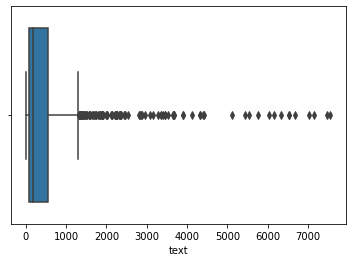

In [ ]:
import seaborn as sns
values = df_text['text'].str.split().str.len()
sns.boxplot(x=values)
plt.show()

In [ ]:
THRESHOLD1 = 58
THRESHOLD2 = 65

characters = df_text['text'].str.split().str.len()
df_text.loc[(characters > THRESHOLD1) & (characters < THRESHOLD2), 'text'].tolist()

['4T Medical. WHAT OUR CUSTOMERS SAY  I have been using products from 4T Medical for over 2 years now. The customer care provided is second to none and I have always been impressed by the products and rapidity of delivery. The training provided has also been excellent, thorough, with good notes, extensive practical sessions & aftercare. Dr Ros Debenham, Radiance MediSpa',
 'Weed Delivery - Buy Marijuana & Cannabis Online. Airgraft 2 sets the new standard in vapor performance. Our groundbreaking premium pods feature extracts from highly respected brands, with 1 gram pods starting at just $20 MSRP. Sign up for a FREE Airgraft account once your order arrives to unlock our safer and awesomer pods using your phone. Enjoy great vapor.',
 'Weed Delivery - Buy Marijuana & Cannabis Online. Airgraft 2 sets the new standard in vapor performance. Our groundbreaking premium pods feature extracts from highly respected brands, with 1 gram pods starting at just $20 MSRP. Sign up for a FREE Airgraft ac

In [ ]:
values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.2) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

56.0

In [ ]:
values.describe()[['25%', '75%']]

25%     73.00
75%    560.25
Name: text, dtype: float64

In [ ]:
df_text

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
1,When Is ADA Compliance Legally Required?. The ...,White Paper,Not provided
2,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
3,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
4,FAQs for some new features available in the Be...,Blog,Not provided
...,...,...,...
1315,RSVP Today for the Digital Health & Human Righ...,Digital event,http://mailchi.mp/hitlab/your-hitlab-weekly-br...
1316,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event,http://www.cparityevent.com/ticket-details-wor...
1317,OCT West Coast- Outsourcing in Clinical Trials...,Event,http://clario.com/insights/events/oct-west-coa...
1318,Life Sciences Panorama 2021 - Oct 06. Senior V...,Event,http://hopin.com/events/life-sciences-panorama...


In [ ]:
df_text[df_text[TARGET].isin(labels_encoded)]

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
2,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
3,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
4,FAQs for some new features available in the Be...,Blog,Not provided
6,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided
...,...,...,...
1313,Fifth Annual Conference. WOCIP is seeking memb...,Event,http://wocip.org/fifth-annual-conference
1316,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event,http://www.cparityevent.com/ticket-details-wor...
1317,OCT West Coast- Outsourcing in Clinical Trials...,Event,http://clario.com/insights/events/oct-west-coa...
1318,Life Sciences Panorama 2021 - Oct 06. Senior V...,Event,http://hopin.com/events/life-sciences-panorama...


In [ ]:
# Important cell # 8

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

if maximum_classes:
  df_text = df_text[df_text[TARGET].isin(labels_encoded)]

  # relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
  # df_text = df_text[df_text[TARGET].isin(relevant_labels)] # this is to erase all classes after 'maximum_classes'
  # # df_text.loc[~df_text[TARGET].isin(relevant_labels), TARGET] = 'MISC' # this is to not erase them, but change their value to 'MISC'

df_text.reset_index(drop=True, inplace=True)

In [ ]:
df_text[TARGET].value_counts()

Blog       185
Webinar    171
Event      169
PR         124
MISC        74
Article     70
Name: label, dtype: int64

In [ ]:
df_text

,text,label,url
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided
3,FAQs for some new features available in the Be...,Blog,Not provided
4,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided
...,...,...,...
788,Xpectives.Health Summit – Xpectives.Health. Xp...,Event,http://xpectives.health/xpectives-health-summit
789,ESMO Congress 2019. The ESMO Congress is the a...,Event,http://www.esmo.org/meetings/past-meetings/esm...
790,Fifth Annual Conference. WOCIP is seeking memb...,Event,http://wocip.org/fifth-annual-conference
791,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event,http://www.cparityevent.com/ticket-details-wor...


In [ ]:
# Important cell # 8
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning text: 551639
Amount of unique words before cleaning text: 48874

Amount of words after cleaning text: 343122
Amount of unique words before cleaning text: 29468


In [ ]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 551639
Amount of unique words before lemmatizing text: 48874

Amount of words after lemmatizing text: 662972
Amount of unique words before lemmatizing text: 22557


In [ ]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 662972
Amount of unique words before cleaning lemmatized text: 22557

Amount of words after cleaning lemmatized text: 328223
Amount of unique words before cleaning lemmatized text: 21376


In [ ]:
df_text.head(3) # df with different techniques for preprocessing of the text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...


In [ ]:
df_text.loc[0, TEXT]

"2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together."

In [ ]:
# df_text.loc[0, 'lemmatized_text']

In [ ]:
# df_text.loc[0, 'lemmatized_cleaned_text']

In [ ]:
def lemmatize_text2(text):
  lemmatized = ' '.join(token.text.lower() for token in nlp(text))
  return lemmatized

df_text['w2v_text'] = df_text[TEXT].apply(lemmatize_text2)

In [ ]:
# print(f"Amount of words before tokenizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
# tokenized = [word_tokenize(string) for string in df_text[TEXT]]
# df_text['tokenized'] = list(map(lambda x: ' '.join(x), tokenized))
# print(f"Amount of words after tokenizing text: {df_text['tokenized'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text['tokenized'].str.split().values, axis=0)).shape[0]}")

In [ ]:
save_variable(df_text, 'df_text')

In [ ]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,MISC,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,Blog,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,Article,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
788,Xpectives.Health Summit – Xpectives.Health. Xp...,Event,http://xpectives.health/xpectives-health-summit,XpectivesHealth Summit XpectivesHealth Xpectiv...,xpective . Health Summit – Xpectives . health ...,xpective Health Summit Xpectives health xpecti...,xpectives . health summit – xpectives . health...
789,ESMO Congress 2019. The ESMO Congress is the a...,Event,http://www.esmo.org/meetings/past-meetings/esm...,ESMO Congress 2019 The ESMO Congress appointme...,ESMO Congress 2019 . the esmo Congress be the ...,ESMO Congress 2019 esmo Congress appointment E...,esmo congress 2019 . the esmo congress is the ...
790,Fifth Annual Conference. WOCIP is seeking memb...,Event,http://wocip.org/fifth-annual-conference,Fifth Annual Conference WOCIP seeking members ...,Fifth Annual Conference . WOCIP be seek member...,Fifth Annual Conference WOCIP seek member inte...,fifth annual conference . wocip is seeking mem...
791,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,Event,http://www.cparityevent.com/ticket-details-wor...,WORLD SMART BIOPROCESSING PHARMA 40 Exhibition...,world SMART BIOPROCESSING : PHARMA 4.0 . exhib...,world SMART BIOPROCESSING PHARMA 40 exhibition...,world smart bioprocessing : pharma 4.0 . exhib...


# 0.9 Further EDA and preprocessing on "df_text"

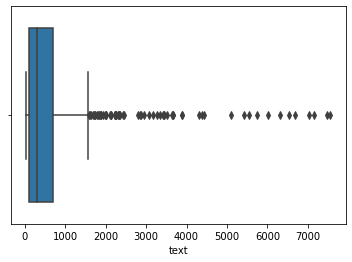

In [ ]:
import seaborn as sns
values = df_text['text'].str.split().str.len()
sns.boxplot(x=values)
plt.show()

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

values.describe()[['25%', '75%']]

In [ ]:
values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

72.0

In [ ]:
values.describe()[['25%', '75%']]

25%    110.5
75%    697.5
Name: text, dtype: float64

In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
326,Teach Yourself Visually Search Engine Optimiza...,Product Page,Teach Yourself Visually Search Engine Optimiza...,teach yourself Visually Search Engine Optimiza...,teach Visually Search Engine Optimization whet...,teach yourself visually search engine optimiza...
327,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page,The Art SEO 2nd Edition Four acknowledged expe...,"the art of seo , 2nd Edition . four acknowledg...",art seo 2nd Edition four acknowledge expert se...,"the art of seo , 2nd edition . four acknowledg..."
328,Submit A Guest Post – Guidelines (Write for Us...,MISC,Submit A Guest Post Guidelines Write Us We acc...,submit a Guest Post – Guidelines ( write for U...,submit Guest Post Guidelines write Us accept G...,submit a guest post – guidelines ( write for u...
329,Fully Managed Magento Hosting — JetRails. Full...,MISC,Fully Managed Magento Hosting JetRails Fully M...,fully manage Magento Hosting — JetRails . full...,fully manage Magento Hosting JetRails fully ma...,fully managed magento hosting — jetrails . ful...


In [ ]:
df_text['w2v_text'].tolist()

['write for us . want to write for us ?   digital lamp , is one of the fastest - growing tech blog . we allow you an endless opportunity for new authors , technical content writers , freelance content writing professionals , and guest writers to technology + “ write for us ” + guest post ( contribute or submit guest post article ) about the topics related to technology , business , internet , gadgets , digital marketing , security , seo , tech blog , etc .   technology is the way progressive for online businesses . why not share your expertise by guest blogging on technology blogs to highlight awareness of this emerging trend .   you will obtain the benefits of being a guest blogger by establishing yourself as an authority in the industry . on top of that , you will build social proof , create a robust online presence , develop new relationships with bloggers and readers and rank better in the search engines .   all you need to do is meet the criteria set out by the technology blogs be

In [ ]:
df_text[TARGET].value_counts()

0    128
7    124
1    110
6     85
2     79
5     66
4     55
3     44
Name: label, dtype: int64

In [ ]:
# df_text[TARGET].replace({1: 5}, inplace=True) # make Blog and Article a single category

In [ ]:
df_text[TARGET].value_counts()

5    176
0    128
7    124
6     85
2     79
4     55
3     44
Name: label, dtype: int64

In [ ]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

# 1. Bag of Words approach

## Preprocessing

In [ ]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [ ]:
# # Working only with df_text2
# df_text = df_text[(df_text['url'] != 'Not provided') & (df_text[TARGET].isin([7, 6, 4, 1, 5]))]

In [ ]:
df_text[TARGET].value_counts()

1    185
4    171
3    169
5    124
2     74
0     70
Name: label, dtype: int64

In [ ]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'lemmatized_cleaned_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((634, 1), (159, 1), (634,), (159,))

In [ ]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.2327


In [ ]:
get_most_common_tokens(df=df_text, column='lemmatized_cleaned_text', amount=10)

[('use', 2073),
 ('patient', 1700),
 ('clinical', 1490),
 ('datum', 1484),
 ('I', 1470),
 ('trial', 1437),
 ('content', 1412),
 ('make', 1376),
 ('company', 1293),
 ('post', 1224)]

In [ ]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [ ]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((634, 416033), (159, 416033))

In [ ]:
# import string

# # STOPWORDS = stop_words.ENGLISH_STOP_WORDS

# #Function for basic cleaning/preprocessing texts
# def clean(doc):
#     # Removal of punctuation marks (.,/\][{} etc) and numbers
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
#     # Removal of stopwords
#     doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
#     return doc.lower()

# string.punctuation

## Modeling

In [ ]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

In [ ]:
for clf in clfs:
  print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
  skf = StratifiedKFold(n_splits=5)
  for train_index, val_index in skf.split(X_train_tr, y_train):
      print_train_val_len_start(train_index, val_index)
      print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

  scores = cross_val_score(clf[1], 
                          X_train_tr,
                          y_train,
                          cv=5)
  
  print_val_scores(scores)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 507, start: [108 112 113], 	VALIDATION index len: 127, start: [0 1 2]
	Mean y: TRAIN: 2.698,	VALIDATION: 2.724
TRAIN index len: 507, start: [0 1 2], 	VALIDATION index len: 127, start: [108 112 113]
	Mean y: TRAIN: 2.698,	VALIDATION: 2.724
TRAIN index len: 507, start: [0 1 2], 	VALIDATION index len: 127, start: [175 179 180]
	Mean y: TRAIN: 2.704,	VALIDATION: 2.701
TRAIN index len: 507, start: [0 1 2], 	VALIDATION index len: 127, start: [264 273 322]
	Mean y: TRAIN: 2.714,	VALIDATION: 2.661
TRAIN index len: 508, start: [0 1 2], 	VALIDATION index len: 126, start: [469 477 485]
	Mean y: TRAIN: 2.703,	VALIDATION: 2.706
Cross validation scores: mean: 0.724, all: [0.693, 0.748, 0.732, 0.74, 0.706]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 507, start: [108 112 113], 	VALIDATION index len: 127, start: [0 1 2]
	Mean y: TRAIN: 2.698,	VALIDATION: 2.724
TRAIN index len: 507, start: [0 1 2], 	VALIDATION index 

In [ ]:
y_train.value_counts(normalize=True)

1    0.233438
4    0.216088
3    0.212934
5    0.156151
2    0.093060
0    0.088328
Name: label, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.232704
3    0.213836
4    0.213836
5    0.157233
2    0.094340
0    0.088050
Name: label, dtype: float64

Checking results on the test set:

In [ ]:
# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test)
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.805031
RandomForest        0.735849
KNN 5               0.654088
SVM C1              0.716981
MultinomialNB       0.597484
Best classifier: LogisticRegression, test accuracy: 0.805


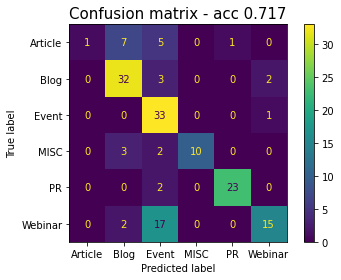


              precision    recall  f1-score   support

     Article       1.00      0.07      0.13        14
        Blog       0.73      0.86      0.79        37
       Event       0.53      0.97      0.69        34
        MISC       1.00      0.67      0.80        15
          PR       0.96      0.92      0.94        25
     Webinar       0.83      0.44      0.58        34

    accuracy                           0.72       159
   macro avg       0.84      0.66      0.65       159
weighted avg       0.79      0.72      0.69       159



In [ ]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

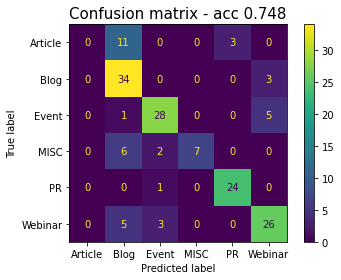


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        14
        Blog       0.60      0.92      0.72        37
       Event       0.82      0.82      0.82        34
        MISC       1.00      0.47      0.64        15
          PR       0.89      0.96      0.92        25
     Webinar       0.76      0.76      0.76        34

    accuracy                           0.75       159
   macro avg       0.68      0.66      0.65       159
weighted avg       0.71      0.75      0.71       159



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

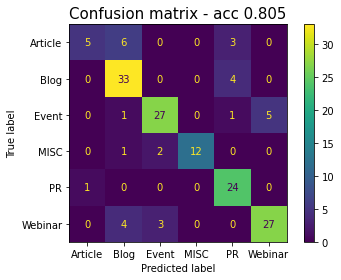


              precision    recall  f1-score   support

     Article       0.83      0.36      0.50        14
        Blog       0.73      0.89      0.80        37
       Event       0.84      0.79      0.82        34
        MISC       1.00      0.80      0.89        15
          PR       0.75      0.96      0.84        25
     Webinar       0.84      0.79      0.82        34

    accuracy                           0.81       159
   macro avg       0.83      0.77      0.78       159
weighted avg       0.82      0.81      0.80       159



In [ ]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [ ]:
X_train_tr.toarray().shape

(634, 416033)

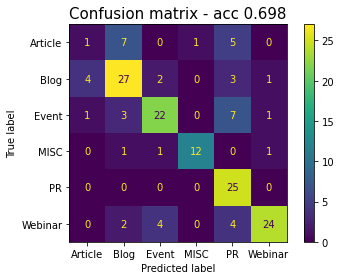


              precision    recall  f1-score   support

     Article       0.17      0.07      0.10        14
        Blog       0.68      0.73      0.70        37
       Event       0.76      0.65      0.70        34
        MISC       0.92      0.80      0.86        15
          PR       0.57      1.00      0.72        25
     Webinar       0.89      0.71      0.79        34

    accuracy                           0.70       159
   macro avg       0.66      0.66      0.64       159
weighted avg       0.70      0.70      0.68       159



In [ ]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [ ]:
print_important_features(clf, features=5)

Class "Article" - 5 most important features: ['000' 'polo ralph' 'polo platform payable' 'polo platform'
 'polo network show']
Class "Blog" - 5 most important features: ['clinical' 'iqvia' '000' 'polo platform' 'polo network show']
Class "MISC" - 5 most important features: ['patient' '000' 'polo platform payable' 'polo platform'
 'polo network show']
Class "Event" - 5 most important features: ['iqvia' 'patient' 'medable' '000' 'polo platform payable']
Class "Webinar" - 5 most important features: ['content' '000' 'polo ralph' 'polo platform payable' 'polo platform']
Class "PR" - 5 most important features: ['000' 'polo ralph lauren' 'polo ralph' 'polo platform payable'
 'polo platform']


In [ ]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
635,rnsa 2021 BrightInsight post conference perspe...,Blog,Event
128,html element reference htmlcolon HyperText Mar...,Article,Blog
268,session 6 Track A Paperless Clinical Trials Ti...,Event,PR
184,sell fact figure appeal emotion salesperson se...,Article,Blog
316,accelerate Clinical Trials Streamlined Project...,Webinar,Event
680,Clinical Data Fraud Detection Mitigation Strat...,Blog,Article
228,Life Sciences Accounting Reporting Healthcare ...,Event,Webinar
131,410 Gone http HyperText Transfer Protocol HTTP...,Article,Blog
260,EUROTOX Congress 2021 dear Friends Colleagues ...,Event,Blog
548,2022 HBS Health Care Conference New Care healt...,MISC,Event


In [ ]:
INDEX = 0
true_index = misclassified_df.index[INDEX]
misclassified_df.loc[true_index, 'lemmatized_cleaned_text']

'rnsa 2021 BrightInsight post conference perspective BrightInsight I pleased represent BrightInsight recent annual meeting Radiological Society North America RSNA Chicago IL RSNA 2021 first business trip since start pandemic great meet dine colleague person network 3 vs familiar virtual meeting approach Chicago great host make sure well protect COVID transmission strict mask wear policy convention center public building attendee also require share proof covid vaccination prior attend conference RSNA world large gathering radiology diagnostic imaging community year theme redefine Radiology disappoint presenter exhibitor excellent job share new idea perspective experience help redefine mean work radiologist focus conference emerge application digital health radiology identify opportunity BrightInsight support development area BrightInsight Platform associate digital health development service one common topic presentation exhibit hall artificial intelligence AI seem though unlimited sele

# 2. Word2Vec approach

In [ ]:
# Deleting heavy variables no longer useful:
try:
  del X_train_tr
  del X_test_tr
except NameError:
  pass

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
save_variable(w2v_model, 'w2v_model')

In [ ]:
w2v_model.word_vec("test").shape

(300,)

In [ ]:
print("Shape of embedding vector", w2v_model["Natural"].shape)
print("First 20 numbers in the embedding of the word Natural\n\n", w2v_model["Natural"][:20])

Shape of embedding vector (300,)
First 20 numbers in the embedding of the word Natural

 [-0.22753906 -0.07617188 -0.06787109 -0.1015625   0.20214844  0.12890625
  0.1796875  -0.11035156  0.01123047  0.01794434  0.12402344  0.11132812
 -0.3359375  -0.01104736 -0.16015625 -0.16113281 -0.13769531  0.4296875
 -0.03979492  0.05297852]


In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,5,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...
542,"Veeva Research Sites Forum, North America. Cli...",4,Veeva Research Sites Forum North America Clini...,"Veeva Research Sites Forum , North America . C...",Veeva Research Sites Forum North America Clini...,"veeva research sites forum , north america . c..."
543,Rethinking the Life Sciences Training Technolo...,6,Rethinking Life Sciences Training Technology E...,rethink the Life Sciences Training Technology ...,rethink Life Sciences Training Technology Ecos...,rethinking the life sciences training technolo...
544,Advancing Meaningful Remote Digital Endpoints ...,6,Advancing Meaningful Remote Digital Endpoints ...,advance Meaningful Remote Digital Endpoints fo...,advance Meaningful Remote Digital Endpoints Ra...,advancing meaningful remote digital endpoints ...
545,How Technology is Transforming Clinical Endpoi...,6,How Technology Transforming Clinical Endpoint ...,how Technology be Transforming Clinical Endpoi...,Technology Transforming Clinical Endpoint Adju...,how technology is transforming clinical endpoi...


In [ ]:
list_of_lists = df_text['w2v_text'].str.split().tolist()

In [ ]:
#Function that takes in the input text dataset in form of list of lists where each sentence is a list of words all the sentences are 
#inside a list
def embedding_feats(list_of_lists, DIMENSION, w2v_model):
    zeros_vector = np.zeros(DIMENSION)
    feats = []
    missing = set()
    missing_sentences = set()
    #Traverse over each sentence
    for tokens in tqdm(list_of_lists):
        # Initially assign zeroes as the embedding vector for the sentence
        feat_for_this = zeros_vector
        #Count the number of words in the embedding for this sentence
        count_for_this = 0
        #Traverse over each word of a sentence
        for token in tokens:
            #Check if the word is in the embedding vector
            if token in w2v_model:
                #Add the vector of the word to vector for the sentence
                feat_for_this += w2v_model[token]
                count_for_this +=1
            #Else assign the missing word to missing set just to have a look at it
            else:
                missing.add(token)
        #If no words are found in the embedding for the sentence
        if count_for_this == 0:
            #Assign all zeroes vector for that sentence
            feats.append(feat_for_this)
            #Assign the missing sentence to missing_sentences just to have a look at it
            missing_sentences.add(' '.join(tokens))
        #Else take average of the values of the embedding for each word to get the embedding of the sentence
        else:
            feats.append(feat_for_this/count_for_this)
    return feats, missing, missing_sentences

In [ ]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 477.67it/s]


In [ ]:
print("Shape of the final embeddings for the sentences", np.array(vectors).shape)
print("First 20 numbers in the embedding of the first train sentence\n\n", np.array(vectors)[0][:20])

Shape of the final embeddings for the sentences (547, 300)
First 20 numbers in the embedding of the first train sentence

 [ 0.01040277  0.04473038  0.02847395  0.11856265 -0.08779861  0.00149163
  0.04686172 -0.06999964  0.05312994  0.02903136 -0.07205876 -0.06800598
  0.01689928  0.03158497 -0.09863865  0.04592628  0.04565423  0.09702129
  0.01392149 -0.04904693]


In [ ]:
len(vectors), vectors[0].shape

(547, (300,))

In [ ]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def accuracy(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [ ]:
from statistics import mean

In [ ]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 432.88it/s]


In [ ]:
y = df_text['label']
test_size = 0.2
random_state = 0

In [ ]:
train_data, val_data, train_cats, val_cats = train_test_split(vectors, y, 
                                                              test_size=test_size,
                                                              stratify=y, 
                                                              random_state=random_state)

In [ ]:
lr = LogisticRegression(max_iter=30000, 
                        class_weight='balanced'
                        ).fit(train_data, train_cats)

In [ ]:
y_vals = val_cats

In [ ]:
y_preds = lr.predict(val_data)

In [ ]:
y_vals.value_counts()

0    26
6    19
1    17
2    16
4    15
3     9
5     8
Name: label, dtype: int64

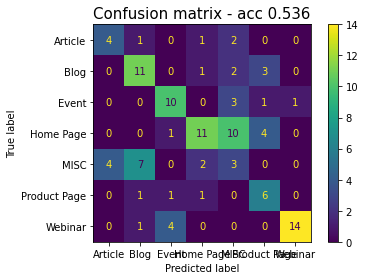

In [ ]:
# Class weight balanced
print_confusion_matrix(y_vals, y_preds, with_report=False)

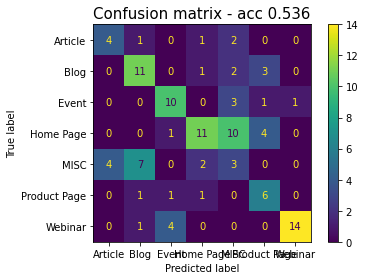

In [ ]:
print_confusion_matrix(y_vals, y_preds, with_report=False)

# 3. BERT approach (Ashwin N)

## Encoding labels

In [ ]:
! pwd

/content/drive/MyDrive/url_classification


In [ ]:
df_text.head(3)

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,3,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."


In [ ]:
df_text[['w2v_text', 'text', 'label']]

,w2v_text,text,label
0,2020 user summit . 2020 user summit * update...,2020 User Summit. 2020 User Summit *UPDATE - ...,3
1,write for us . want to write for us ? digita...,Write For Us. Want to Write for Us? Digital L...,2
2,"write for us . yes , you . we ’re always looki...","Write for Us. Yes, you. We’re always looking f...",2
3,faqs for some new features available in the be...,FAQs for some new features available in the Be...,1
4,the best nootropic stack to replace adderall &...,The Best Nootropic Stack to Replace Adderall &...,0
...,...,...,...
788,xpectives . health summit – xpectives . health...,Xpectives.Health Summit – Xpectives.Health. Xp...,3
789,esmo congress 2019 . the esmo congress is the ...,ESMO Congress 2019. The ESMO Congress is the a...,3
790,fifth annual conference . wocip is seeking mem...,Fifth Annual Conference. WOCIP is seeking memb...,3
791,world smart bioprocessing : pharma 4.0 . exhib...,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,3


In [ ]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [ ]:
df_text[TARGET].value_counts()

1    185
4    171
3    169
5    124
2     74
0     70
Name: label, dtype: int64

## Working with fixed validation data

### Preprocessing

In [ ]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,3,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,0,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
788,Xpectives.Health Summit – Xpectives.Health. Xp...,3,http://xpectives.health/xpectives-health-summit,XpectivesHealth Summit XpectivesHealth Xpectiv...,xpective . Health Summit – Xpectives . health ...,xpective Health Summit Xpectives health xpecti...,xpectives . health summit – xpectives . health...
789,ESMO Congress 2019. The ESMO Congress is the a...,3,http://www.esmo.org/meetings/past-meetings/esm...,ESMO Congress 2019 The ESMO Congress appointme...,ESMO Congress 2019 . the esmo Congress be the ...,ESMO Congress 2019 esmo Congress appointment E...,esmo congress 2019 . the esmo congress is the ...
790,Fifth Annual Conference. WOCIP is seeking memb...,3,http://wocip.org/fifth-annual-conference,Fifth Annual Conference WOCIP seeking members ...,Fifth Annual Conference . WOCIP be seek member...,Fifth Annual Conference WOCIP seek member inte...,fifth annual conference . wocip is seeking mem...
791,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,3,http://www.cparityevent.com/ticket-details-wor...,WORLD SMART BIOPROCESSING PHARMA 40 Exhibition...,world SMART BIOPROCESSING : PHARMA 4.0 . exhib...,world SMART BIOPROCESSING PHARMA 40 exhibition...,world smart bioprocessing : pharma 4.0 . exhib...


In [ ]:
# Cell 9
test_size = 0.2
val_size = 0.1
random_state = 0

# Important cell # 9
column_used = 'text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/val_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((554, 1), (80, 1), (159, 1), (554,), (80,), (159,))

In [ ]:
y_train.value_counts()

1    129
4    120
3    118
5     86
2     52
0     49
Name: label, dtype: int64

In [ ]:
y_val.value_counts()

1    19
3    17
4    17
5    13
0     7
2     7
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

1    37
3    34
4    34
5    25
2    15
0    14
Name: label, dtype: int64

In [ ]:
X_train

,text
298,"Halloran Town Hall. Patient centricity, at its..."
239,ISPOR 2021. The live Virtual ISPOR 2021 was he...
411,CASTOR Launches Scalable Patient Enrollment an...
170,Write For Us. Guest Post As you’ve reached th...
99,Content Marketing Institute. Thanks for your i...
...,...
29,Topic Clusters Won’t Save You: How to Focus & ...
695,Making the digital leap in underwriting. Under...
87,Write for us and get noticed by top developers...
48,Brand Identity: How to Develop a Unique & Memo...


In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict(
    {
    'train': Dataset.from_dict(
        {'text': X_train[column_used],
         'label': y_train,
         }
         ),
    'validation': Dataset.from_dict(
        {'text': X_val[column_used],
         'label': y_val,
         }
         ),
    'test': Dataset.from_dict(
        {'text': X_test[column_used],
         'label': y_test,
         }
         ),
    }
    )

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 554
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 159
    })
})

In [ ]:
train_ds = dataset['train']

In [ ]:
print(train_ds[:5])

{'text': ['Halloran Town Hall. Patient centricity, at its core, is bringing the voice of the patient into clinical trial design right from the start to ensure the trial can achieve its objectives and endpoints while also creating a positive experience for the patients and their families. But what patient centricity really means and what it looks like in trial design is commonly misunderstood, and unfortunately, there are major risks for sponsors and patients when the understanding isn’t aligned.  Please join our Halloran-hosted virtual Town Hall on February 25th from 11:00am-12:00pm EST on “Hybrid Models and the Path to Designing Patient-Centric Clinical Trials.” Jennie Sheridan and John Ferraro of Halloran with be talking with Jane Myles, VP of Clinical Trial Innovation at Curebase, Mari Maurer, VP of Clinical Operations at Escape Bio and Alicia C. Staley, VP of Patient Engagement at Medidata Solutions on the opportunities and value of building patient centric principles into hybrid c

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
# model_ckpt = 'bert-base-uncased' # Node: 'tf_bert_for_sequence_classification/bert/encoder/layer_._8/intermediate/Gelu/mul_1' failed to allocate memory
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
text = "Tokenizing text is a core task of NLP 2021. See you on 31/12/2022."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 25682, 1012, 2156, 2017, 2006, 2861, 1013, 2260, 1013, 16798, 2475, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '2021', '.', 'see', 'you', 'on', '31', '/', '12', '/', '202', '##2', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp 2021. see you on 31 / 12 / 2022. [SEP]


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(dataset["train"][:2])) 

{'input_ids': [[101, 2534, 18842, 2237, 2534, 1012, 5776, 9358, 7277, 3012, 1010, 2012, 2049, 4563, 1010, 2003, 5026, 1996, 2376, 1997, 1996, 5776, 2046, 6612, 3979, 2640, 2157, 2013, 1996, 2707, 2000, 5676, 1996, 3979, 2064, 6162, 2049, 11100, 1998, 2203, 26521, 2096, 2036, 4526, 1037, 3893, 3325, 2005, 1996, 5022, 1998, 2037, 2945, 1012, 2021, 2054, 5776, 9358, 7277, 3012, 2428, 2965, 1998, 2054, 2009, 3504, 2066, 1999, 3979, 2640, 2003, 4141, 28947, 1010, 1998, 6854, 1010, 2045, 2024, 2350, 10831, 2005, 13162, 1998, 5022, 2043, 1996, 4824, 3475, 1521, 1056, 13115, 1012, 3531, 3693, 2256, 2534, 18842, 1011, 4354, 7484, 2237, 2534, 2006, 2337, 10965, 2013, 2340, 1024, 4002, 3286, 1011, 2260, 1024, 27995, 9765, 2006, 1523, 8893, 4275, 1998, 1996, 4130, 2000, 12697, 5776, 1011, 9358, 7277, 6612, 7012, 1012, 1524, 27557, 13243, 1998, 2198, 10768, 11335, 3217, 1997, 2534, 18842, 2007, 2022, 3331, 2007, 4869, 27056, 1010, 21210, 1997, 6612, 3979, 8144, 2012, 9526, 15058, 1010, 16266, 5003,

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 554
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 80
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 159
    })
})

In [ ]:
from transformers import TFAutoModel 
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.156513  , -0.18619666,  0.05277651, ..., -0.11881146,
          0.06620602,  0.5470156 ],
        [-0.3575139 , -0.6483559 , -0.0617902 , ..., -0.3040195 ,
          0.35076872,  0.5220684 ],
        [-0.27718496, -0.4459445 ,  0.1818425 , ..., -0.09477941,
         -0.00757464,  0.9958281 ],
        [-0.28408563, -0.3916768 ,  0.37525558, ..., -0.21505757,
         -0.11725189,  1.0526482 ],
        [ 0.2660821 , -0.509364  , -0.31801355, ..., -0.42029813,
          0.01444179, -0.21489467],
        [ 0.9440609 ,  0.01117263, -0.47139442, ...,  0.14394675,
         -0.7287836 , -0.16194907]]], dtype=float32)>, hidden_states=None, attentions=None)

In [ ]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [ ]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(
        batch["text"], 
        padding=True, 
        truncation=True, 
        return_tensors='tf',
        )
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [ ]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 554
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 80
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 159
    })
})

In [ ]:
import numpy as np
X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
X_valid_ = np.array(dataset_hidden["validation"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])
y_valid_ = np.array(dataset_hidden["validation"]["label"])
X_train_.shape, X_valid_.shape, y_train_.shape, y_valid_.shape

((554, 768), (80, 768), (554,), (80,))

In [ ]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])
X_test_.shape, y_test.shape

((159, 768), (159,))

In [ ]:
X_train_

array([[-1.83306813e-01, -1.17192589e-01, -4.96630073e-02, ...,
        -1.29731506e-01,  4.38509822e-01,  3.29618007e-01],
       [-3.74829113e-01, -2.12982923e-01,  1.68911248e-01, ...,
        -8.69623572e-02,  2.91482329e-01,  2.59089977e-01],
       [-3.16042840e-01, -1.11525901e-01, -9.27955657e-03, ...,
        -1.70893043e-01,  2.90265232e-01,  1.83716863e-01],
       ...,
       [ 9.13214087e-02,  2.52455473e-04, -1.88614652e-02, ...,
        -1.65609598e-01,  4.62531894e-01,  2.56751180e-01],
       [ 3.23106535e-02, -6.04377873e-03, -2.53485560e-01, ...,
        -2.30418563e-01,  3.99230152e-01,  4.85906482e-01],
       [-3.67969185e-01, -1.86468363e-01, -2.52821952e-01, ...,
         4.37261946e-02,  4.23747361e-01,  2.85452187e-01]])

In [ ]:
X_valid_test_ = np.concatenate([X_valid_, X_test_])
X_valid_.shape, X_test_.shape, X_valid_test_.shape

((80, 768), (159, 768), (239, 768))

In [ ]:
y_valid_test_ = np.concatenate([y_valid_, y_test_])
y_valid_.shape, y_test_.shape, y_valid_test_.shape

((80,), (159,), (239,))

### Modeling - machine learning approach:

In [ ]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_valid_test_, y_valid_test_)

0.8158995815899581

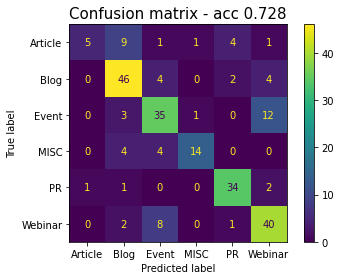


              precision    recall  f1-score   support

     Article       0.83      0.24      0.37        21
        Blog       0.71      0.82      0.76        56
       Event       0.67      0.69      0.68        51
        MISC       0.88      0.64      0.74        22
          PR       0.83      0.89      0.86        38
     Webinar       0.68      0.78      0.73        51

    accuracy                           0.73       239
   macro avg       0.77      0.68      0.69       239
weighted avg       0.74      0.73      0.72       239



In [ ]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_pred = predict(rf_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

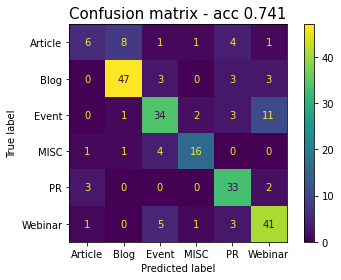


              precision    recall  f1-score   support

     Article       0.55      0.29      0.37        21
        Blog       0.82      0.84      0.83        56
       Event       0.72      0.67      0.69        51
        MISC       0.80      0.73      0.76        22
          PR       0.72      0.87      0.79        38
     Webinar       0.71      0.80      0.75        51

    accuracy                           0.74       239
   macro avg       0.72      0.70      0.70       239
weighted avg       0.73      0.74      0.73       239



In [ ]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_, 
                y_train_)

y_pred = predict(svc_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

In [ ]:
X_train_.shape

(555, 768)

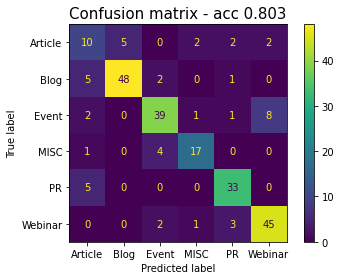


              precision    recall  f1-score   support

     Article       0.43      0.48      0.45        21
        Blog       0.91      0.86      0.88        56
       Event       0.83      0.76      0.80        51
        MISC       0.81      0.77      0.79        22
          PR       0.82      0.87      0.85        38
     Webinar       0.82      0.88      0.85        51

    accuracy                           0.80       239
   macro avg       0.77      0.77      0.77       239
weighted avg       0.81      0.80      0.80       239



In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

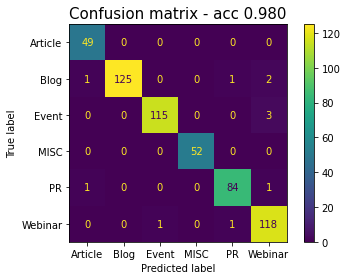


              precision    recall  f1-score   support

     Article       0.96      1.00      0.98        49
        Blog       1.00      0.97      0.98       129
       Event       0.99      0.97      0.98       118
        MISC       1.00      1.00      1.00        52
          PR       0.98      0.98      0.98        86
     Webinar       0.95      0.98      0.97       120

    accuracy                           0.98       554
   macro avg       0.98      0.98      0.98       554
weighted avg       0.98      0.98      0.98       554



In [ ]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_)
print_confusion_matrix(y_train_, y_pred_train, with_report=True)

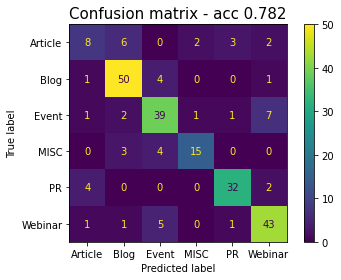


              precision    recall  f1-score   support

     Article       0.53      0.38      0.44        21
        Blog       0.81      0.89      0.85        56
       Event       0.75      0.76      0.76        51
        MISC       0.83      0.68      0.75        22
          PR       0.86      0.84      0.85        38
     Webinar       0.78      0.84      0.81        51

    accuracy                           0.78       239
   macro avg       0.76      0.73      0.74       239
weighted avg       0.78      0.78      0.78       239



In [ ]:
lr_clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)
y_probs = lr_clf.predict_proba(X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

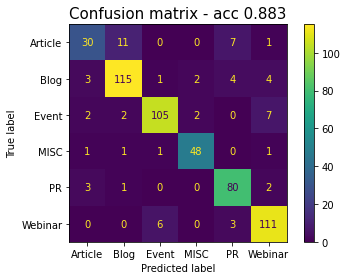


              precision    recall  f1-score   support

     Article       0.77      0.61      0.68        49
        Blog       0.88      0.89      0.89       129
       Event       0.93      0.89      0.91       118
        MISC       0.92      0.92      0.92        52
          PR       0.85      0.93      0.89        86
     Webinar       0.88      0.93      0.90       120

    accuracy                           0.88       554
   macro avg       0.87      0.86      0.87       554
weighted avg       0.88      0.88      0.88       554



In [ ]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_)
print_confusion_matrix(y_train_, y_pred_train, with_report=True)

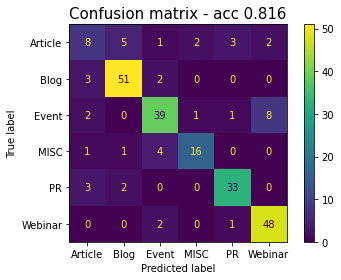


              precision    recall  f1-score   support

     Article       0.47      0.38      0.42        21
        Blog       0.86      0.91      0.89        56
       Event       0.81      0.76      0.79        51
        MISC       0.84      0.73      0.78        22
          PR       0.87      0.87      0.87        38
     Webinar       0.83      0.94      0.88        51

    accuracy                           0.82       239
   macro avg       0.78      0.77      0.77       239
weighted avg       0.81      0.82      0.81       239



In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

In [ ]:
# lr_clf = fit_model(LogisticRegression(
#     max_iter=3000, 
#     class_weight='balanced',
#     solver='saga', # default: 'lbfgs' 
#     penalty='elasticnet', # default: 'l2',
#     l1_ratio=0.9, # only relevant when penalty='elasticnet'
#     ), 
#                 X_train_, 
#                 y_train_)

# y_pred = predict(lr_clf, X_valid_test_)
# y_probs = lr_clf.predict_proba(X_valid_test_)

# print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

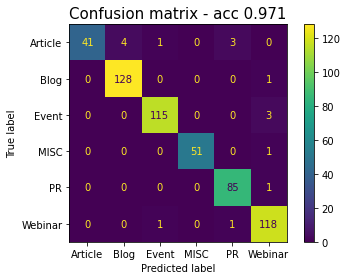


              precision    recall  f1-score   support

     Article       1.00      0.84      0.91        49
        Blog       0.97      0.99      0.98       129
       Event       0.98      0.97      0.98       118
        MISC       1.00      0.98      0.99        52
          PR       0.96      0.99      0.97        86
     Webinar       0.95      0.98      0.97       120

    accuracy                           0.97       554
   macro avg       0.98      0.96      0.97       554
weighted avg       0.97      0.97      0.97       554



In [ ]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_)
print_confusion_matrix(y_train_, y_pred_train, with_report=True)

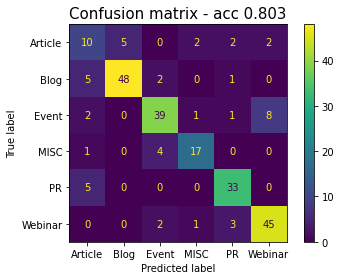


              precision    recall  f1-score   support

     Article       0.43      0.48      0.45        21
        Blog       0.91      0.86      0.88        56
       Event       0.83      0.76      0.80        51
        MISC       0.81      0.77      0.79        22
          PR       0.82      0.87      0.85        38
     Webinar       0.82      0.88      0.85        51

    accuracy                           0.80       239
   macro avg       0.77      0.77      0.77       239
weighted avg       0.81      0.80      0.80       239



In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_pred = predict(lr_clf, X_valid_test_)
y_probs = lr_clf.predict_proba(X_valid_test_)

print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

In [ ]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,3,Not provided,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Not provided,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Not provided,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,Not provided,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,0,Not provided,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
788,Xpectives.Health Summit – Xpectives.Health. Xp...,3,http://xpectives.health/xpectives-health-summit,XpectivesHealth Summit XpectivesHealth Xpectiv...,xpective . Health Summit – Xpectives . health ...,xpective Health Summit Xpectives health xpecti...,xpectives . health summit – xpectives . health...
789,ESMO Congress 2019. The ESMO Congress is the a...,3,http://www.esmo.org/meetings/past-meetings/esm...,ESMO Congress 2019 The ESMO Congress appointme...,ESMO Congress 2019 . the esmo Congress be the ...,ESMO Congress 2019 esmo Congress appointment E...,esmo congress 2019 . the esmo congress is the ...
790,Fifth Annual Conference. WOCIP is seeking memb...,3,http://wocip.org/fifth-annual-conference,Fifth Annual Conference WOCIP seeking members ...,Fifth Annual Conference . WOCIP be seek member...,Fifth Annual Conference WOCIP seek member inte...,fifth annual conference . wocip is seeking mem...
791,WORLD SMART BIOPROCESSING: PHARMA 4.0. Exhibit...,3,http://www.cparityevent.com/ticket-details-wor...,WORLD SMART BIOPROCESSING PHARMA 40 Exhibition...,world SMART BIOPROCESSING : PHARMA 4.0 . exhib...,world SMART BIOPROCESSING PHARMA 40 exhibition...,world smart bioprocessing : pharma 4.0 . exhib...


In [ ]:
labels_encoded

{'Article': 0, 'Blog': 1, 'MISC': 2, 'Event': 3, 'Webinar': 4, 'PR': 5}

In [ ]:
mask = y_pred != y_valid_test_

In [ ]:
X_valid_test = np.concatenate([X_val, X_test]) # concatenate
X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,text,y_true,y_pred
1,alt attribute. Alternative text that appears w...,Article,MISC
13,Thoughts on the Whitehouse.gov switch to Drupa...,Article,Blog
17,ObvioHealth Provide Virtual Clinical Trials th...,PR,Article
21,RESI Conference – Early stage investors matche...,Event,Article
23,Study Shows Business Blogging Leads to 55% Mor...,Blog,Article
24,Readability: The Optimal Line Length – Article...,Article,Blog
25,DDD East Midlands 2021. About The aim is to c...,MISC,Event
26,Exclusive: Radiohead Sell 1.2million Copies Of...,Article,Blog
37,Addressing Roadblocks in Decentralized Trials....,Article,Webinar
43,Apply now for the Women In Tech Insights Day -...,MISC,Event


In [ ]:
misclassified_df.shape

(47, 3)

In [ ]:
df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
df_merged.index = misclassified_df.index
df_merged

,text,y_true,y_pred,url
1,alt attribute. Alternative text that appears w...,Article,MISC,Not provided
13,Thoughts on the Whitehouse.gov switch to Drupa...,Article,Blog,Not provided
17,ObvioHealth Provide Virtual Clinical Trials th...,PR,Article,http://marketersmedia.com/obviohealth-provide-...
21,RESI Conference – Early stage investors matche...,Event,Article,http://resiconference.com/
23,Study Shows Business Blogging Leads to 55% Mor...,Blog,Article,Not provided
24,Readability: The Optimal Line Length – Article...,Article,Blog,Not provided
25,DDD East Midlands 2021. About The aim is to c...,MISC,Event,http://www.eventbrite.co.uk/e/ddd-east-midland...
26,Exclusive: Radiohead Sell 1.2million Copies Of...,Article,Blog,Not provided
37,Addressing Roadblocks in Decentralized Trials....,Article,Webinar,http://www.pharmexec.com/view/addressing-roadb...
43,Apply now for the Women In Tech Insights Day -...,MISC,Event,http://accenture.headstartapp.com/role/602e608...


In [ ]:
df_merged.shape

(47, 4)

In [ ]:
df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences.head()

,y_true,y_pred
1,0,2
13,0,1
17,5,0
21,3,0
23,1,0


In [ ]:
df_confidences.shape

(47, 2)

In [ ]:
mask = y_pred != y_valid_test_

In [ ]:
y_probs[mask][:3]

array([[1.98956374e-01, 5.14216518e-02, 7.43038184e-01, 4.42624603e-03,
        3.11849831e-04, 1.84569430e-03],
       [2.96572344e-02, 9.30148820e-01, 1.14286400e-02, 1.31503350e-02,
        5.79978339e-04, 1.50349922e-02],
       [3.92643538e-01, 2.07243552e-01, 4.27740759e-02, 7.19697663e-03,
        4.94137851e-02, 3.00728072e-01]])

In [ ]:
df_confidences['y_pred']

1      2
13     1
17     0
21     0
23     0
24     1
25     3
26     1
37     4
43     3
44     0
53     4
54     5
56     4
57     4
63     1
71     2
72     0
76     5
79     4
80     3
84     4
93     4
96     0
102    3
110    3
123    5
124    2
131    2
136    5
147    5
155    5
157    0
164    4
166    5
174    0
184    3
194    0
195    4
208    0
211    4
219    3
222    3
225    0
229    0
237    1
238    0
Name: y_pred, dtype: int64

In [ ]:
confidence_pred = y_probs[mask, df_confidences['y_pred']]
confidence_pred

array([0.74303818, 0.93014882, 0.39264354, 0.58231217, 0.86176101,
       0.76060818, 0.99165659, 0.41995427, 0.92390948, 0.74341065,
       0.62563284, 0.79273011, 0.63652768, 0.85319055, 0.66708656,
       0.62292228, 0.90298665, 0.50406091, 0.45531387, 0.69940967,
       0.97395989, 0.64335959, 0.90117402, 0.62460208, 0.69673993,
       0.51631499, 0.53002437, 0.44174991, 0.88897808, 0.42745813,
       0.47853494, 0.35789191, 0.30785667, 0.51477572, 0.57296441,
       0.46850747, 0.32985646, 0.49207576, 0.81016634, 0.57961832,
       0.77160284, 0.9673337 , 0.50233845, 0.67868848, 0.99676195,
       0.77586982, 0.42514485])

In [ ]:
confidence_true = y_probs[mask, df_confidences['y_true']]
confidence_true

array([0.19895637, 0.02965723, 0.30072807, 0.0580433 , 0.12152323,
       0.08386171, 0.00625644, 0.07819943, 0.0012288 , 0.02910618,
       0.34796212, 0.01814608, 0.24004463, 0.14279919, 0.26136224,
       0.15763393, 0.00151918, 0.46433616, 0.33089271, 0.23858116,
       0.01879007, 0.31117647, 0.04333687, 0.34058127, 0.0475382 ,
       0.11840247, 0.16854913, 0.39598794, 0.04440311, 0.34933154,
       0.47768518, 0.27683303, 0.2268467 , 0.47377707, 0.28582404,
       0.45288355, 0.28534568, 0.03310298, 0.06842503, 0.05857279,
       0.15236996, 0.01236997, 0.10188047, 0.28569379, 0.00307145,
       0.20197394, 0.14426195])

In [ ]:
df_merged['conf_true'] = confidence_true.round(2)
df_merged['conf_pred'] = confidence_pred.round(2)

In [ ]:
df_merged.head()

,text,y_true,y_pred,url,conf_true,conf_pred
1,alt attribute. Alternative text that appears w...,Article,MISC,Not provided,0.20,0.74
13,Thoughts on the Whitehouse.gov switch to Drupa...,Article,Blog,Not provided,0.03,0.93
17,ObvioHealth Provide Virtual Clinical Trials th...,PR,Article,http://marketersmedia.com/obviohealth-provide-...,0.30,0.39
21,RESI Conference – Early stage investors matche...,Event,Article,http://resiconference.com/,0.06,0.58
23,Study Shows Business Blogging Leads to 55% Mor...,Blog,Article,Not provided,0.12,0.86


In [ ]:
df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]

In [ ]:
df_merged.shape

(47, 6)

In [ ]:
df_merged

,url,text,y_true,conf_true,y_pred,conf_pred
1,Not provided,alt attribute. Alternative text that appears w...,Article,0.20,MISC,0.74
13,Not provided,Thoughts on the Whitehouse.gov switch to Drupa...,Article,0.03,Blog,0.93
17,http://marketersmedia.com/obviohealth-provide-...,ObvioHealth Provide Virtual Clinical Trials th...,PR,0.30,Article,0.39
21,http://resiconference.com/,RESI Conference – Early stage investors matche...,Event,0.06,Article,0.58
23,Not provided,Study Shows Business Blogging Leads to 55% Mor...,Blog,0.12,Article,0.86
24,Not provided,Readability: The Optimal Line Length – Article...,Article,0.08,Blog,0.76
25,http://www.eventbrite.co.uk/e/ddd-east-midland...,DDD East Midlands 2021. About The aim is to c...,MISC,0.01,Event,0.99
26,Not provided,Exclusive: Radiohead Sell 1.2million Copies Of...,Article,0.08,Blog,0.42
37,http://www.pharmexec.com/view/addressing-roadb...,Addressing Roadblocks in Decentralized Trials....,Article,0.00,Webinar,0.92
43,http://accenture.headstartapp.com/role/602e608...,Apply now for the Women In Tech Insights Day -...,MISC,0.03,Event,0.74


In [ ]:
save_variable(df_merged, 'df_merged')

In [ ]:
misclassified_urls = df_merged['url'].tolist()
misclassified_urls

['Not provided',
 'Not provided',
 'http://marketersmedia.com/obviohealth-provide-virtual-clinical-trials-that-gathers-better-data/89006637',
 'http://resiconference.com/',
 'Not provided',
 'Not provided',
 'http://www.eventbrite.co.uk/e/ddd-east-midlands-2021-tickets-146129646707',
 'Not provided',
 'http://www.pharmexec.com/view/addressing-roadblocks-in-decentralized-trials',
 'http://accenture.headstartapp.com/role/602e608e68117c0008dd4e0d',
 'http://www.statnews.com/2021/08/19/verily-signalpath-optellum-lung-cancer/',
 'http://www.transformfest.com/global',
 'http://www.outsourcing-pharma.com/Article/2021/03/08/ObvioHealth-announces-upgraded-decentralized-trial-platform',
 'http://clario.com/insights/events/dct-decentralized-clinical-trials/',
 'http://www.iqvia.com/events/2021/01/iqvia-commercial-compliance-our-2021-roadmap',
 'Not provided',
 'http://www.starburst.io/info/datanova2022/',
 'Not provided',
 'http://www.curebase.com/webinars/telemedicine-applications-to-decentraliz

In [ ]:
wrong_conf_pred = np.max(y_probs[mask], axis=1)
wrong_conf_pred[:3]

array([0.74303818, 0.93014882, 0.39264354])

In [ ]:
right_conf_pred = np.max(y_probs[~mask], axis=1)
right_conf_pred[:3]

array([0.93758784, 0.5527941 , 0.37648404])

In [ ]:
assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [ ]:
print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

Average confidence of misclassified samples: 0.6550
Average confidence of correctly classified samples: 0.8232


In [ ]:
print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

Median confidence of misclassified samples: 0.6365
Median confidence of correctly classified samples: 0.8746


In [ ]:
# Comparison between using 'l1' vs 'l2' regularization (without class Article, with Home Page):
# Acc test set - 'l1': 0.812, 'l2': 0.808
# Acc train set - 'l1': 0.898, 'l2': 0.983
# Average confidence of misclassified samples - 'l1': 0.5134, 'l2': 0.6213
# Average confidence of correctly classified samples - 'l1': 0.6977, 'l2': 0.8412
# Median confidence of misclassified samples - 'l1': 0.4976, 'l2': 0.5665
# Median confidence of correctly classified samples - 'l1': 0.7224, 'l2': 0.8995

In [ ]:
# Comparison between using 'l1' vs 'l2' regularization (with class Article, without Home Page):
# Acc test set - 'l1': 0.717, 'l2': 0.759
# Acc train set - 'l1': 0.886, 'l2': 0.988
# Average confidence of misclassified samples - 'l1': 0.581, 'l2': 0.600
# Average confidence of correctly classified samples - 'l1': 0.671, 'l2': 0.660
# Median confidence of misclassified samples - 'l1': 0.564, 'l2': 0.5813
# Median confidence of correctly classified samples - 'l1': 0.698, 'l2': 0.6841

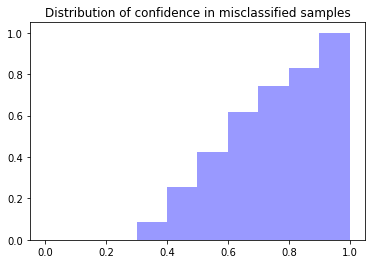

In [ ]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.4)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.4, cumulative=1)
plt.title('Distribution of confidence in misclassified samples')
plt.show()

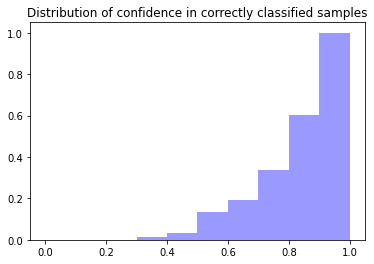

In [ ]:
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.4)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.4, cumulative=1)
plt.title('Distribution of confidence in correctly classified samples')
plt.show()

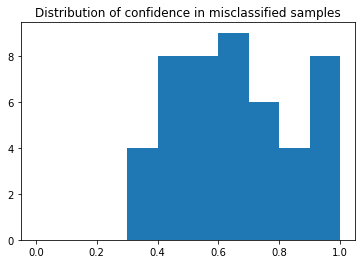

In [ ]:
density=None
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
plt.title('Distribution of confidence in misclassified samples')
plt.show()

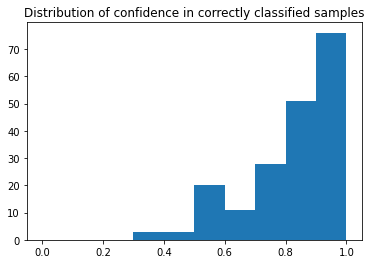

In [ ]:
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
plt.title('Distribution of confidence in correctly classified samples')
plt.show()

In [ ]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# # misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()

In [ ]:
lr_clf.score(X_valid_test_, y_valid_test_)

0.803347280334728

In [ ]:
X_valid_test = np.concatenate([X_val, X_test]) # concatenate
X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

### Modeling - deep learning approach v1:

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
# The column names to convert to TensorFlow tensors
# from transformers import DataCollatorForTokenClassification
# from transformers import DefaultDataCollator
from transformers import DataCollatorWithPadding

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_eval_dataset = dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_train_dataset

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

In [ ]:
num_labels = len(y_train.value_counts())

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.1
DISTILBERT_ATT_DROPOUT = 0.1
 
# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout=DISTILBERT_DROPOUT, 
    attention_dropout=DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
    num_labels=num_labels,
    )
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
# tf_model = TFDistilBertModel.from_pretrained(
#     'distilbert-base-uncased', 
#     config=config
#     )

# # # Make tf_model layers untrainable
# for layer in tf_model.layers:
#     layer.trainable = False

In [ ]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    config=config, 
    # num_labels=num_labels,
    )
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_38', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# With:
# DISTILBERT_DROPOUT = 0.1
# DISTILBERT_ATT_DROPOUT = 0.1

epochs = 1000
patience = 5

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
    )

callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
    )

history = tf_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset, 
    epochs=epochs,
    callbacks=[callback]
    )

Epoch 1/1000
35/35 [==============================] - 48s 1s/step - loss: 1.7437 - sparse_categorical_accuracy: 0.3045 - val_loss: 1.6903 - val_sparse_categorical_accuracy: 0.4790
Epoch 2/1000
35/35 [==============================] - 35s 1s/step - loss: 1.6298 - sparse_categorical_accuracy: 0.4685 - val_loss: 1.5329 - val_sparse_categorical_accuracy: 0.6555
Epoch 3/1000
35/35 [==============================] - 36s 1s/step - loss: 1.4366 - sparse_categorical_accuracy: 0.6739 - val_loss: 1.3178 - val_sparse_categorical_accuracy: 0.6975
Epoch 4/1000
35/35 [==============================] - 35s 1s/step - loss: 1.2257 - sparse_categorical_accuracy: 0.7423 - val_loss: 1.1296 - val_sparse_categorical_accuracy: 0.7059
Epoch 5/1000
35/35 [==============================] - 36s 1s/step - loss: 1.0422 - sparse_categorical_accuracy: 0.7622 - val_loss: 0.9742 - val_sparse_categorical_accuracy: 0.7563
Epoch 6/1000
35/35 [==============================] - 35s 1s/step - loss: 0.8939 - sparse_categorica

KeyboardInterrupt: ignored

In [ ]:
tf.keras.models.save_model(
    tf_model, 
    filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89', 
    overwrite=True, 
    save_format='tf'
    )

In [ ]:
tf_model.save('/content/drive/MyDrive/Brew/my_model_val0.87_test0.8')

In [ ]:
! pwd

/content/drive/.shortcut-targets-by-id/1vLy-uUgLo6ivB3DawGntodciS6HG1L58/url_classification


In [ ]:
tf.saved_model.save(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
from tensorflow.keras.models import load_model
tf_model2 = load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 

In [ ]:
tf_model2 = tf.saved_model.load('/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
tf.keras.models.save_model(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
tf_model

In [ ]:
tf_model2 = tf.keras.models.load_model(filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89') 
# # why doesn't it work when running the next cell with the loaded model?

In [ ]:
custom_objects = {"TFAutoModelForSequenceClassification": TFAutoModelForSequenceClassification}

tf_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Brew/my_model_delete', custom_objects=custom_objects)

In [ ]:
loss, train_accuracy = tf_model2.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

ValueError: ignored

In [ ]:
loss, train_accuracy = tf_model.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

35/35 [==============================] - 10s 296ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.9928
Loss: 0.10425467044115067	 Train Accuracy: 0.9927927851676941


In [ ]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

8/8 [==============================] - 2s 285ms/step - loss: 0.5874 - sparse_categorical_accuracy: 0.8403
Loss: 0.5873854756355286	 Eval Accuracy: 0.8403361439704895


In [ ]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

8/8 [==============================] - 2s 285ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.8908
Loss: 0.3818075656890869	 Test Accuracy: 0.8907563090324402


In [ ]:
output_logits = tf_model.predict(tf_test_dataset).logits
y_pred = np.argmax(output_logits, axis=-1)

8/8 [==============================] - 4s 278ms/step


In [ ]:
y_pred

array([4, 5, 5, 4, 3, 3, 0, 1, 5, 2, 3, 3, 1, 5, 0, 4, 1, 4, 3, 1, 5, 1,
       3, 1, 2, 2, 5, 2, 3, 4, 5, 3, 5, 3, 3, 2, 5, 4, 2, 1, 4, 1, 4, 4,
       4, 3, 4, 3, 4, 1, 3, 3, 0, 3, 1, 5, 4, 2, 3, 0, 3, 5, 1, 4, 2, 1,
       5, 4, 1, 1, 1, 4, 2, 2, 4, 5, 4, 2, 1, 3, 1, 5, 1, 3, 4, 3, 3, 1,
       5, 1, 5, 3, 4, 3, 0, 1, 1, 4, 4, 1, 4, 3, 3, 5, 4, 1, 1, 3, 3, 0,
       4, 1, 5, 4, 5, 4, 3, 1, 1])

In [ ]:
y_probs = tf.nn.softmax(output_logits)
y_probs[:3]

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0.01213919, 0.00994258, 0.00947644, 0.04158583, 0.91965204,
        0.00720389],
       [0.3774553 , 0.05021018, 0.04787833, 0.01990625, 0.02151035,
        0.48303968],
       [0.02125797, 0.00986786, 0.00969888, 0.00922654, 0.00685588,
        0.9430928 ]], dtype=float32)>

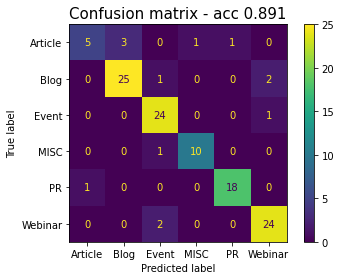


              precision    recall  f1-score   support

     Article       0.83      0.50      0.62        10
        Blog       0.89      0.89      0.89        28
       Event       0.86      0.96      0.91        25
        MISC       0.91      0.91      0.91        11
          PR       0.95      0.95      0.95        19
     Webinar       0.89      0.92      0.91        26

    accuracy                           0.89       119
   macro avg       0.89      0.86      0.86       119
weighted avg       0.89      0.89      0.89       119



In [ ]:
print_confusion_matrix(y_test, y_pred, with_report=True)

In [ ]:
y_pred

array([4, 5, 5, 4, 3, 3, 0, 1, 5, 2, 3, 3, 1, 5, 0, 4, 1, 4, 3, 1, 5, 1,
       3, 1, 2, 2, 5, 2, 3, 4, 5, 3, 5, 3, 3, 2, 5, 4, 2, 1, 4, 1, 4, 4,
       4, 3, 4, 3, 4, 1, 3, 3, 0, 3, 1, 5, 4, 2, 3, 0, 3, 5, 1, 4, 2, 1,
       5, 4, 1, 1, 1, 4, 2, 2, 4, 5, 4, 2, 1, 3, 1, 5, 1, 3, 4, 3, 3, 1,
       5, 1, 5, 3, 4, 3, 0, 1, 1, 4, 4, 1, 4, 3, 3, 5, 4, 1, 1, 3, 3, 0,
       4, 1, 5, 4, 5, 4, 3, 1, 1])

In [ ]:
y_test

355    4
414    0
378    5
326    4
222    3
      ..
461    5
628    4
577    3
83     1
654    1
Name: label, Length: 119, dtype: int64

In [ ]:
mask = y_pred != y_test
mask

355    False
414     True
378    False
326    False
222    False
       ...  
461    False
628    False
577    False
83     False
654    False
Name: label, Length: 119, dtype: bool

In [ ]:
y_pred

array([4, 5, 5, 4, 3, 3, 0, 1, 5, 2, 3, 3, 1, 5, 0, 4, 1, 4, 3, 1, 5, 1,
       3, 1, 2, 2, 5, 2, 3, 4, 5, 3, 5, 3, 3, 2, 5, 4, 2, 1, 4, 1, 4, 4,
       4, 3, 4, 3, 4, 1, 3, 3, 0, 3, 1, 5, 4, 2, 3, 0, 3, 5, 1, 4, 2, 1,
       5, 4, 1, 1, 1, 4, 2, 2, 4, 5, 4, 2, 1, 3, 1, 5, 1, 3, 4, 3, 3, 1,
       5, 1, 5, 3, 4, 3, 0, 1, 1, 4, 4, 1, 4, 3, 3, 5, 4, 1, 1, 3, 3, 0,
       4, 1, 5, 4, 5, 4, 3, 1, 1])

In [ ]:
np.array(y_test)

array([4, 0, 5, 4, 3, 3, 0, 1, 5, 2, 1, 3, 1, 5, 0, 4, 1, 4, 3, 1, 5, 1,
       3, 1, 2, 2, 5, 0, 3, 4, 5, 3, 5, 3, 3, 2, 5, 4, 2, 1, 4, 1, 4, 4,
       3, 3, 4, 3, 4, 0, 3, 3, 0, 3, 0, 5, 4, 2, 3, 5, 3, 5, 1, 1, 2, 1,
       5, 4, 1, 1, 1, 1, 2, 2, 4, 5, 4, 2, 1, 3, 1, 5, 1, 3, 4, 2, 3, 1,
       5, 1, 5, 3, 4, 4, 0, 1, 1, 4, 4, 1, 4, 4, 3, 5, 4, 0, 1, 3, 3, 0,
       4, 1, 5, 4, 5, 4, 3, 1, 1])

In [ ]:
len(y_test), len(y_pred)

(119, 119)

In [ ]:
misclassified_df_nn = pd.DataFrame(
    {'y_true': y_test[mask].reset_index(drop=True).replace(labels_decoded),
     'y_pred': pd.Series(y_pred[mask]).replace(labels_decoded),
     }).set_index(y_test[mask].index)
misclassified_df_nn

,y_true,y_pred
414,Article,PR
635,Blog,Event
131,Article,MISC
581,Event,Webinar
92,Article,Blog
82,Article,Blog
399,PR,Article
664,Blog,Webinar
84,Blog,Webinar
548,MISC,Event


In [ ]:
# I can merge with url/text using the index of y_test, do it later.

In [ ]:
df_confidences_nn = misclassified_df_nn[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences_nn.head()

,y_true,y_pred
414,0,5
635,1,3
131,0,2
581,3,4
92,0,1


In [ ]:
y_probs_array = np.array(y_probs)

In [ ]:
confidence_pred_nn = y_probs_array[mask, df_confidences_nn['y_pred']]
confidence_pred_nn

array([0.48303968, 0.9520294 , 0.38810995, 0.47096214, 0.74444205,
       0.9432786 , 0.5317493 , 0.49251008, 0.6403236 , 0.96351135,
       0.9651472 , 0.9011265 , 0.94320387], dtype=float32)

In [ ]:
confidence_true_nn = y_probs_array[mask, df_confidences_nn['y_true']]
confidence_true_nn

array([0.3774553 , 0.01674964, 0.3667001 , 0.44553837, 0.18093933,
       0.02908214, 0.36548197, 0.1368382 , 0.19136502, 0.00810583,
       0.00595913, 0.05903158, 0.02912136], dtype=float32)

In [ ]:
misclassified_df_nn['conf_true'] = confidence_true_nn.round(2)
misclassified_df_nn['conf_pred'] = confidence_pred_nn.round(2)
misclassified_df_nn.head()

,y_true,y_pred,conf_true,conf_pred
414,Article,PR,0.38,0.48
635,Blog,Event,0.02,0.95
131,Article,MISC,0.37,0.39
581,Event,Webinar,0.45,0.47
92,Article,Blog,0.18,0.74


In [ ]:
misclassified_df_nn = misclassified_df_nn[['y_true', 'conf_true', 'y_pred', 'conf_pred']]
misclassified_df_nn

,y_true,conf_true,y_pred,conf_pred
414,Article,0.38,PR,0.48
635,Blog,0.02,Event,0.95
131,Article,0.37,MISC,0.39
581,Event,0.45,Webinar,0.47
92,Article,0.18,Blog,0.74
82,Article,0.03,Blog,0.94
399,PR,0.37,Article,0.53
664,Blog,0.14,Webinar,0.49
84,Blog,0.19,Webinar,0.64
548,MISC,0.01,Event,0.96


In [ ]:
save_variable(misclassified_df_nn, 'df_merged_nn')

In [ ]:
wrong_conf_pred = np.max(y_probs_array[mask], axis=1)
wrong_conf_pred[:3]

array([0.48303968, 0.9520294 , 0.38810995], dtype=float32)

In [ ]:
right_conf_pred = np.max(y_probs_array[~mask], axis=1)
right_conf_pred[:3]

array([0.91965204, 0.9430928 , 0.9596139 ], dtype=float32)

In [ ]:
assert y_probs_array.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [ ]:
print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

Average confidence of misclassified samples: 0.7246
Average confidence of correctly classified samples: 0.8973


In [ ]:
print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

Median confidence of misclassified samples: 0.7444
Median confidence of correctly classified samples: 0.9418


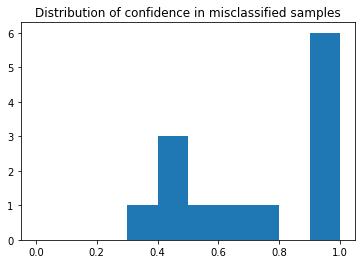

In [ ]:
density=None
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
plt.title('Distribution of confidence in misclassified samples')
plt.show()

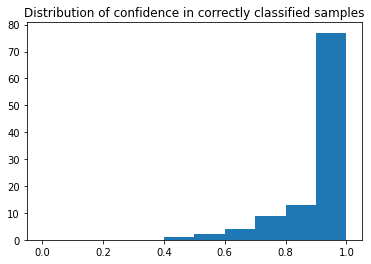

In [ ]:
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
plt.title('Distribution of confidence in correctly classified samples')
plt.show()

In [ ]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_test, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()

### Modeling - deep learning approach v2:

In [ ]:
# Cell 9
test_size = 0.15
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/test_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((483, 1), (104, 1), (104, 1), (483,), (104,), (104,))

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict({
    'train': Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'validation': Dataset.from_dict({'text': X_val[column_used],'label': y_val}),
    'test': Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 483
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
})

In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained('distilgpt2')

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer2.pad_token = tokenizer2.eos_token

In [ ]:
tokenizer2

PreTrainedTokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'})

In [ ]:
tokenizer2.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [ ]:
transformers.__version__

'4.25.1'

In [ ]:
datasets.__version__

'2.7.1'

In [ ]:
# ds = datasets.Dataset.from_pandas(df_text)

In [ ]:
# ds

Dataset({
    features: ['text', 'label', 'url', 'cleaned_text', 'lemmatized_text', 'lemmatized_cleaned_text', 'w2v_text'],
    num_rows: 691
})

In [ ]:
# ds[0]

{'text': "2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together.",
 'label': 4,
 'url': 'Not provided',
 'cleaned_text': '2020 User Summit 2020 User Summi

In [ ]:
ds_encoded2 = ds.map(lambda row: tokenizer2(row['w2v_text'], 
                                          padding='max_length', 
                                          truncation=True,
                                          max_length=512 # is this ok? i just put a number
                                          ), 
                    batched=True,
                    remove_columns=['url', 'text', 'cleaned_text', 'lemmatized_text', 'lemmatized_cleaned_text', 'w2v_text'],
                    )

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
ds_encoded2

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 691
})

In [ ]:
ds_encoded2[0]

{'label': 4,
 'input_ids': [42334,
  2836,
  14237,
  764,
  12131,
  2836,
  14237,
  220,
  220,
  1635,
  4296,
  532,
  9960,
  1105,
  400,
  837,
  12131,
  1635,
  220,
  220,
  351,
  262,
  7044,
  5197,
  286,
  262,
  32095,
  286,
  262,
  3298,
  17645,
  286,
  262,
  39849,
  312,
  12,
  1129,
  9471,
  290,
  262,
  2785,
  3048,
  837,
  356,
  765,
  345,
  284,
  760,
  326,
  674,
  8475,
  318,
  284,
  1394,
  674,
  14237,
  21736,
  3338,
  290,
  7981,
  764,
  220,
  220,
  981,
  674,
  936,
  2836,
  14237,
  318,
  655,
  517,
  621,
  257,
  1227,
  1497,
  837,
  356,
  389,
  8564,
  284,
  674,
  7534,
  705,
  3067,
  290,
  3747,
  764,
  503,
  286,
  281,
  20038,
  286,
  13041,
  290,
  2328,
  837,
  356,
  423,
  3066,
  284,
  14241,
  262,
  12131,
  2836,
  14237,
  287,
  262,
  1266,
  1393,
  286,
  477,
  2950,
  764,
  220,
  220,
  981,
  356,
  2911,
  326,
  356,
  477,
  460,
  290,
  481,
  8277,
  287,
  3487,
  4568,
  355,
  881

In [ ]:
ds_encoded2 = ds_encoded2.with_format('tf')

In [ ]:
ds_encoded2[0]

{'label': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 'input_ids': <tf.Tensor: shape=(512,), dtype=int64, numpy=
 array([42334,  2836, 14237,   764, 12131,  2836, 14237,   220,   220,
         1635,  4296,   532,  9960,  1105,   400,   837, 12131,  1635,
          220,   220,   351,   262,  7044,  5197,   286,   262, 32095,
          286,   262,  3298, 17645,   286,   262, 39849,   312,    12,
         1129,  9471,   290,   262,  2785,  3048,   837,   356,   765,
          345,   284,   760,   326,   674,  8475,   318,   284,  1394,
          674, 14237, 21736,  3338,   290,  7981,   764,   220,   220,
          981,   674,   936,  2836, 14237,   318,   655,   517,   621,
          257,  1227,  1497,   837,   356,   389,  8564,   284,   674,
         7534,   705,  3067,   290,  3747,   764,   503,   286,   281,
        20038,   286, 13041,   290,  2328,   837,   356,   423,  3066,
          284, 14241,   262, 12131,  2836, 14237,   287,   262,  1266,
         1393,   286,   477,  295

In [ ]:
tokenizer2.decode(ds_encoded2[0]['input_ids'])

"2020 user summit. 2020 user summit   * update - march 12th, 2020 *   with the ongoing coverage of the seriousness of the global outbreak of the covid-19 virus and the potential effects, we want you to know that our priority is to keep our summit attendees safe and informed.   while our ac user summit is just more than a month away, we are sensitive to our clients'travel and safety. out of an abundance of caution and concern, we have decided to cancel the 2020 user summit in the best interest of all involved.   while we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.   registration fees will be credited back to all clients who have registered for the summit.   thank you for your patience and understanding as we work through unprecedented times together.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [ ]:
tokenizer2.decode(ds_encoded2[0]['input_ids'], skip_special_tokens=True)

"2020 user summit. 2020 user summit   * update - march 12th, 2020 *   with the ongoing coverage of the seriousness of the global outbreak of the covid-19 virus and the potential effects, we want you to know that our priority is to keep our summit attendees safe and informed.   while our ac user summit is just more than a month away, we are sensitive to our clients'travel and safety. out of an abundance of caution and concern, we have decided to cancel the 2020 user summit in the best interest of all involved.   while we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.   registration fees will be credited back to all clients who have registered for the summit.   thank you for your patience and understanding as we work through unprecedented times together."

In [ ]:
tf_ds = ds_encoded2.to_tf_dataset(
    batch_size=4,
    shuffle=True
)

In [ ]:
X = next(iter(tf_ds))

In [ ]:
X

{'label': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 7, 0, 0])>,
 'input_ids': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
 array([[11299,  7625,   416, ..., 50256, 50256, 50256],
        [   88, 35505,  4078, ...,   331, 35505,   220],
        [45609,   384,    78, ..., 50256, 50256, 50256],
        [ 1069, 11766,  4875, ..., 50256, 50256, 50256]])>,
 'attention_mask': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>}

In [ ]:
# Total number of minibatches in the dataset
len(tf_ds)

173

In [ ]:
num_labels

NameError: ignored

In [ ]:
from transformers import TFAutoModelForSequenceClassification
model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

## Working with validation split

In [ ]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
dataset = DatasetDict({
    'train':Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'test':Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

In [ ]:
train_ds = dataset['train']

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded

tf_model = TFAutoModel.from_pretrained(model_ckpt)

dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])

X_train_.shape, y_train_.shape

In [ ]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])

In [ ]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_test_, y_test_)

In [ ]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_test_pred = predict(rf_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_, 
                y_train_)

y_test_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_test_pred = predict(lr_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
dataset_encoded

In [ ]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForTokenClassification
from transformers import DefaultDataCollator


tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator
                                                          )

tf_train_dataset

In [ ]:
tokenizer_columns

In [ ]:
dataset_encoded["train"]['input_ids', 'attention_mask']

In [ ]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator
                                                              )

In [ ]:
tf_model_vs = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
tf_train_array = np.array(tf_train_dataset)

In [ ]:
tf_train_dataset

In [ ]:
tf_train_array

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100
patience = 3
validation_split = 0.15

tf_model_vs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy()
)

callback = EarlyStopping(monitor='val_loss',
                          patience=patience,
                          restore_best_weights=True)

tf_model_vs.fit(tf_train_array, 
             validation_split=validation_split, 
             epochs=epochs,
             callbacks=[callback]
             )